In [ ]:
!pip install kaggle

In [5]:
from google.colab import files

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download adityajn105/flickr8k

flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile 
  
# specifying the name of the zip file
file = "flickr8k.zip"
  
# open the zip file in read mode
with ZipFile(file, 'r') as zip: 
    # list all the contents of the zip file
    zip.printdir() 
  
    # extract all files
    print('extraction...') 
    zip.extractall() 
    print('Done!')

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')  

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model

In [11]:
img = load_img('/content/Images/1000268201_693b08cb0e.jpg')

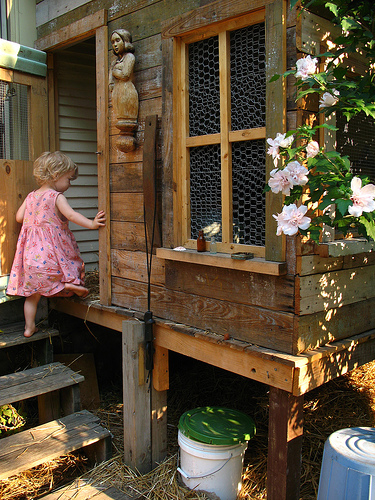

In [12]:
img

In [14]:
len(os.listdir('/content/Images'))

8091

In [15]:
with open('/content/captions.txt') as f:
    data = f.read()

In [16]:
data = data.split('\n')
data[1:6]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [17]:
model = VGG16()
model = Model(inputs=model.inputs,outputs = model.layers[-2].output)
model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [20]:
from tqdm.notebook import tqdm

features = {}
path = '/content/Images'

for img_name in tqdm(os.listdir(path)):
    img_path = os.path.join(path,img_name)
    img = load_img(img_path,target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape(1,224,224,3)
    img = preprocess_input(img)
    feature = model.predict(img)
    img_id = img_name.split('.')[0]
    features[img_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [21]:
import pickle
pickle.dump(features,open(os.path.join('/content', 'features.pkl'), 'wb')) 

In [24]:
with open('/content/captions.txt') as f:
    next(f)
    doc = f.read()

In [39]:
mapping = {}

for line in tqdm(doc.split('\n')):
    tokens = line.split(',')
    if len(tokens)<2:
        continue
    img_id,caption = tokens[0],tokens[1:]
    img_id = img_id.split('.')[0]
    caption = ' '.join(caption)

    if img_id not in mapping:
        mapping[img_id] = []
    mapping[img_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [40]:
mapping['1000268201_693b08cb0e']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [41]:
len(mapping)

8091

In [42]:
import re

def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = re.sub('[^a-zA-Z]',' ',caption)
            caption = 'start ' + " ".join([word for word in caption.split() if len(word)>1]) + ' end'
            captions[i] = caption


In [43]:
clean(mapping)

In [44]:
mapping['1000268201_693b08cb0e']


['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [45]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [47]:
len(all_captions)

40455

In [48]:
all_captions[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [51]:
vocab_size

8425

In [52]:
max_length = max([len(caption.split()) for caption in all_captions])

In [53]:
max_length

35

In [54]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [75]:
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0
        

In [71]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,Embedding,Dense,Dropout,LSTM,add

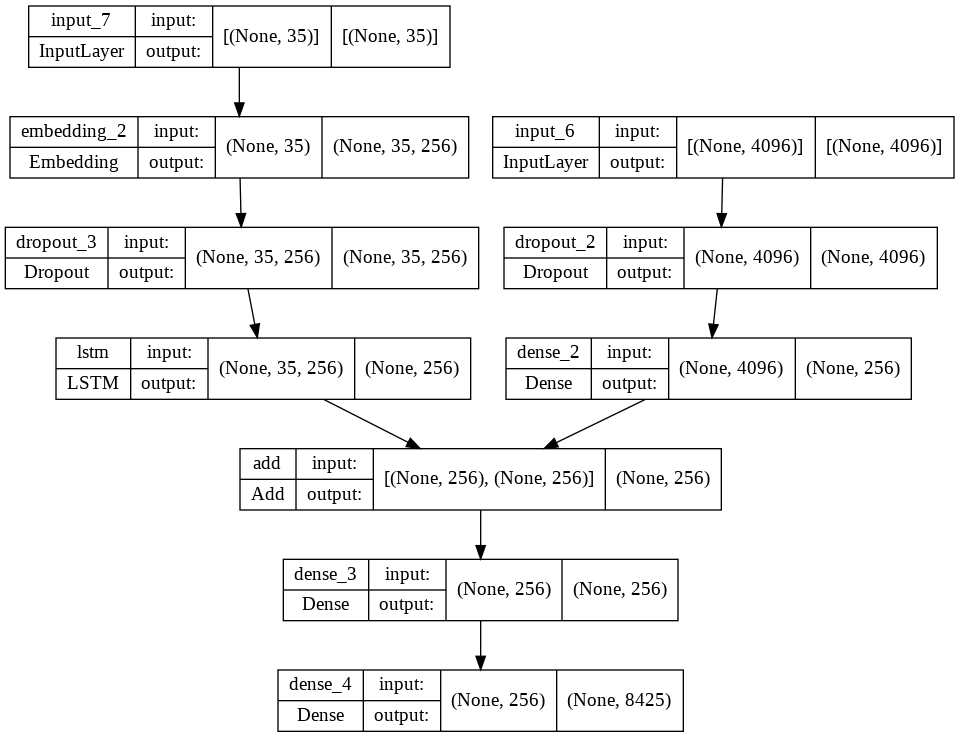

In [73]:
inputs_1 = Input(shape = (4096,))
encoder1 = Dropout(0.2)(inputs_1)
encoder2 = Dense(256,activation='relu')(encoder1)

inputs_2 = Input(shape=(max_length,))
seq_enc1 = Embedding(vocab_size,256,mask_zero = True)(inputs_2)
seq_enc2 = Dropout(0.4)(seq_enc1)
seq_enc3 = LSTM(256)(seq_enc2)

decoder = add([encoder2,seq_enc3])
decoder1 = Dense(256,activation='relu')(decoder)
outputs = Dense(vocab_size,activation = 'softmax')(decoder1)

model = Model(inputs = [inputs_1,inputs_2],outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [76]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 59s 259ms/step - loss: 2.1461


In [77]:
model.save('/content/best_model.h5')


In [78]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [94]:
def predict_caption(model,feature,tokenizer,max_length):

    text = 'start'
    for i in range(max_length):

        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = pad_sequences([sequence],max_length)
        prediction = model.predict([feature,sequence])
        prediction = np.argmax(prediction)
        word = idx_to_word(prediction,tokenizer)
        if word is None:
            break
        text += ' '+ word
        if word=='end':
            break
    return text

In [102]:
def generate_caption(img_id):
    path = img_id+'.jpg'
    img = load_img(os.path.join('/content/Images',path))
    prediction = predict_caption(model,features[img_id],tokenizer,max_length)

    print(prediction)
    plt.imshow(img)
    plt.show()

start two dogs are playing with each other end


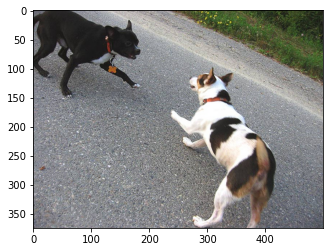

In [96]:
generate_caption('1001773457_577c3a7d70')

In [97]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print(corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

0.5261236595938855


start man in black shorts and shorts is walking down the street end


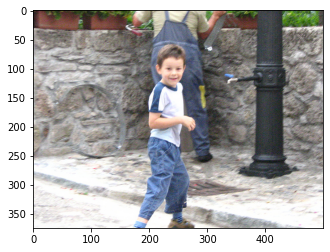

In [98]:
generate_caption('1015118661_980735411b')

start group of people are walking down city street end


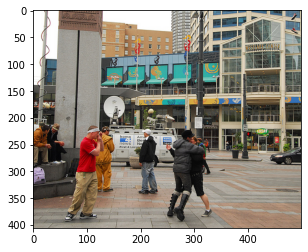

start young girl in red shirt and pink shorts is riding red jump end


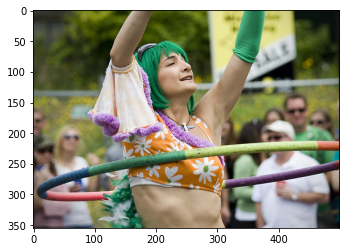

start young girl in pink shirt is jumping in the air end


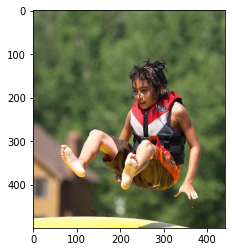

start dog runs along the beach end


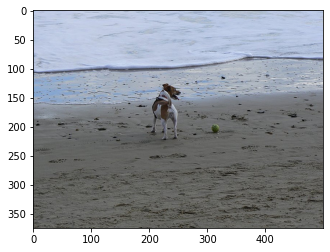

start brown dog is running through the grass end


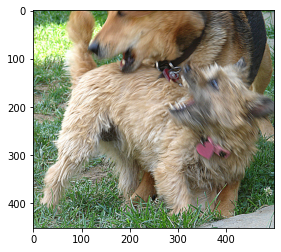

In [103]:
for i in range(5):
    generate_caption(np.random.choice(test))